# Synopsis generation and Interpolation

In [12]:
import cv2
import numpy as np

from collections import OrderedDict

In [13]:
frames = {}
with open("./data/video-2-synopsis.csv", 'r') as f:
    first = True
    for line in f:
        if first:
            first = False
            continue
        f, tag, x, y, w, h, nf = line.split(",")
        if int(nf) not in frames.keys():
            frames[int(nf)] = []
            
        frames[int(nf)].append({
            'tag': int(tag), 
            'file': f'./video-2-raw/{tag}_{f}.jpg', 
            'x': int(x), 
            'y': int(y), 
            'w': int(w), 
            'h': int(h), 
            'frame': int(f)
        })

Interpolate the missing frames

In [14]:
from scipy.interpolate import UnivariateSpline

def unique_tags(frames):
    tags = set()
    for frame_content in frames.values():
        for object_data in frame_content:
            tags.add(object_data.get('tag'))
    return tags
    

def extract_frames_by_tag(frames, tag):
    keys = list(frames.keys())
    keys.sort()
    tagframes = {}
    for new_frame in keys:
        for data in frames[new_frame]:
            if tag == data.get('tag'):
                tagframes[new_frame] = data.copy()
                break
    return tagframes
    

def params_to_interpolate_by_tag(tagframes):
    x, y, f = [], [], []
    ord_tagframes = OrderedDict(sorted(tagframes.items()))
    for frame, content in tagframes.items():
        x.append(content.get('x'))
        y.append(content.get('y'))
        f.append(content.get('frame'))
    return x, y, f
        
    
def complete_frames(frames):
    """
    """
    tags = unique_tags(frames)
    last_frame = max(list(frames.keys()))
    interpolated_frames = { i:[] for i in range(1, last_frame + 1) }
    for tag in tags:
        tagframes = extract_frames_by_tag(frames, tag)
        frames_of_tag = list(tagframes.keys())
        frames_of_tag.sort()
        X, Y, F = params_to_interpolate_by_tag(tagframes)
        for i in range(1, len(frames_of_tag)):
            prev_frame = frames_of_tag[i-1]
            curr_frame = frames_of_tag[i]
            xp  = [ prev_frame, curr_frame ]
            ypX = [ tagframes[prev_frame]['x'], tagframes[curr_frame]['x'] ]
            ypY = [ tagframes[prev_frame]['y'], tagframes[curr_frame]['y'] ]
            if curr_frame == prev_frame + 1: continue
            for j in range(prev_frame + 1, curr_frame):     
                x_pred = np.interp(j, xp, ypX)
                y_pred = np.interp(j, xp, ypY)
                tagframes[j] = tagframes[prev_frame].copy()
                tagframes[j]['x'] = x_pred
                tagframes[j]['y'] = y_pred
        for frame in range(1, last_frame):
            if frame not in tagframes:
                continue
            interpolated_frames[frame].append(tagframes[frame])
    return interpolated_frames

Testing interpolation

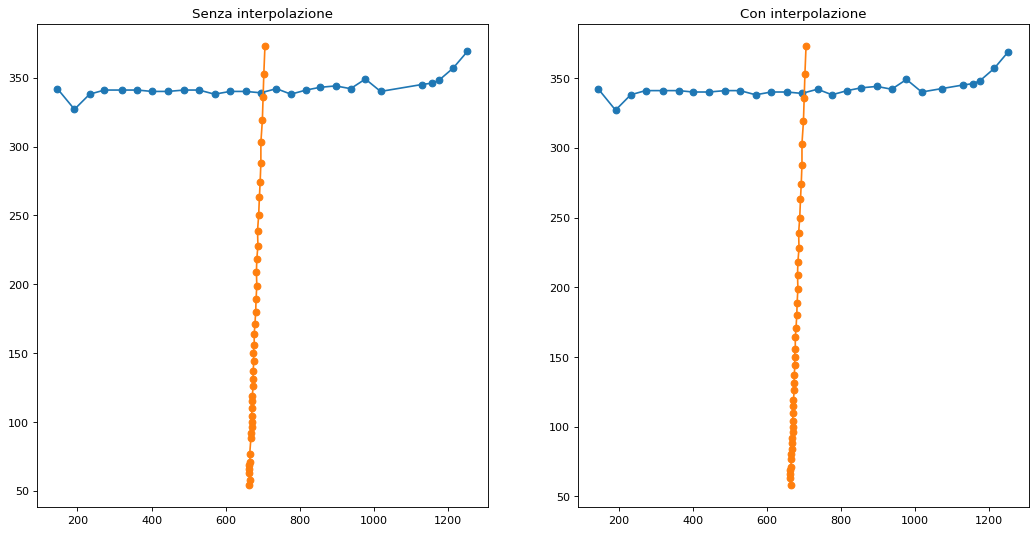

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8), dpi=80)

plt.subplot(1, 2, 1) # row 1, col 2 index 1

#tubes = [1, 2, 5, 6, 9, 10]
tubes = [3, 4]

for tag in tubes:
    oggetto = extract_frames_by_tag(frames, tag)
    x = np.array([ frame.get('x') for idx, frame in oggetto.items() ])
    y = np.array([ frame.get('y') for idx, frame in oggetto.items() ])            
    plt.gca().invert_yaxis()
    plt.scatter(x, y)
    plt.plot(x,y)
    
plt.title("Senza interpolazione")

plt.subplot(1, 2, 2) # index 2

interp_frames = complete_frames(frames)
for tag in tubes:
    oggetto = extract_frames_by_tag(interp_frames, tag)
    x = np.array([ frame.get('x') for idx, frame in oggetto.items() ])
    y = np.array([ frame.get('y') for idx, frame in oggetto.items() ])
    plt.gca().invert_yaxis()
    plt.scatter(x, y)
    plt.plot(x,y)

plt.title("Con interpolazione")    
plt.show()


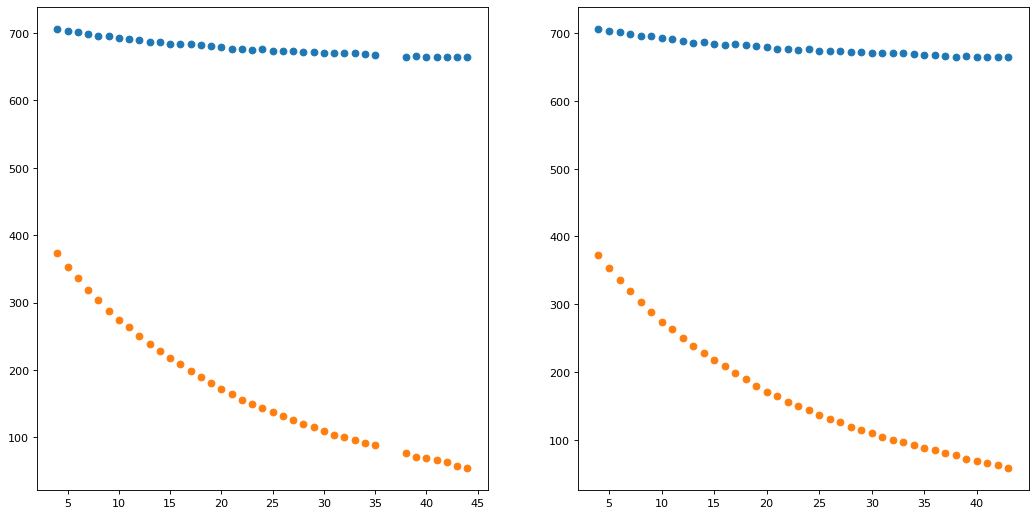

In [16]:
plt.figure(figsize=(16, 8), dpi=80)

TAG = 4

#---------- No interpolazione

plt.subplot(1, 2, 1) # row 1, col 2 index 1
frames_no_interp = extract_frames_by_tag(frames, TAG)
x = list(frames_no_interp.keys())
yx = [ frame.get('x') for frame in frames_no_interp.values() ]
yy = [ frame.get('y') for frame in frames_no_interp.values() ]
plt.scatter(x,yx)
plt.scatter(x,yy)

#---------- Interpolazione

plt.subplot(1, 2, 2) # row 1, col 2 index 1
interp_frames = complete_frames(frames)
frames_no_interp = extract_frames_by_tag(interp_frames, TAG)
x = list(frames_no_interp.keys())
yx = [ frame.get('x') for frame in frames_no_interp.values() ]
yy = [ frame.get('y') for frame in frames_no_interp.values() ]
plt.scatter(x,yx)
plt.scatter(x,yy)

plt.show()

In [17]:
import datetime

def generate_synopsis(frames, output, fps, bgpath, interp=False):
    """
    """
    _frames = frames.copy()
    max_frame = max(list(_frames.keys()))
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output, fourcc, fps, (1280,1080))
    if interp:
        _frames = complete_frames(_frames)    
    for num_frame in range(1, max_frame + 1):
        frame = cv2.imread(bgpath)
        if num_frame in _frames.keys():           
            objects = sorted(_frames[num_frame], key=lambda d: d['tag'], reverse=True) 
            for obj in objects:
                fr = obj.get('frame')
                s_img = cv2.imread(obj.get('file'))
                x = int(obj.get('x'))
                y = int(obj.get('y'))
                w = int(obj.get('w'))
                h = int(obj.get('h'))
                
                # check delle dimensioni
                #img_h, img_w = s_img.shape
                #frm_h, frm_w = frame.shape
                #add_h = 
                print(obj.get('file'))
                extr_frame = frame[y:y+s_img.shape[0], x:x+s_img.shape[1]]
                print('frame', extr_frame.shape)
                print('patch', s_img.shape)
                
                time = str(datetime.timedelta(seconds=int(fr/30)))
                
                try:
                    frame[y:y+s_img.shape[0], x:x+s_img.shape[1]] = s_img
                    cv2.rectangle(frame,(x,y),(x+w,y+h),thickness=2,color=(255,0,0))
                    cv2.putText(frame, time,(x,y-20),cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)
                except:
                    continue
        try:
            out.write(frame[:-200])
        except:
            continue
    out.release()

In [18]:
fps = 30
output = 'video-2-synopsis.mp4'
output_int = 'video-2-synopsis.mp4'
bgpath = 'real_background_2.jpg'

generate_synopsis(frames, output_int, fps, bgpath, True)

./video-2-raw/3_143.jpg
frame (140, 344, 3)
patch (140, 344, 3)
./video-2-raw/3_144.jpg
frame (152, 339, 3)
patch (152, 339, 3)
./video-2-raw/3_145.jpg
frame (145, 343, 3)
patch (145, 343, 3)
./video-2-raw/4_367.jpg
frame (222, 169, 3)
patch (222, 169, 3)
./video-2-raw/3_146.jpg
frame (144, 359, 3)
patch (144, 359, 3)
./video-2-raw/4_368.jpg
frame (201, 158, 3)
patch (201, 158, 3)
./video-2-raw/3_147.jpg
frame (142, 344, 3)
patch (142, 344, 3)
./video-2-raw/4_369.jpg
frame (192, 148, 3)
patch (192, 148, 3)
./video-2-raw/3_148.jpg
frame (141, 336, 3)
patch (141, 336, 3)
./video-2-raw/4_370.jpg
frame (184, 142, 3)
patch (184, 142, 3)
./video-2-raw/3_149.jpg
frame (143, 339, 3)
patch (143, 339, 3)
./video-2-raw/4_371.jpg
frame (165, 137, 3)
patch (165, 137, 3)
./video-2-raw/3_150.jpg
frame (142, 349, 3)
patch (142, 349, 3)
./video-2-raw/4_372.jpg
frame (151, 126, 3)
patch (151, 126, 3)
./video-2-raw/3_151.jpg
frame (142, 338, 3)
patch (142, 338, 3)
./video-2-raw/4_373.jpg
frame (149, 124,